In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mdst

from sklearn.cluster import SpectralClustering, KMeans, MeanShift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [3]:
path = r'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'

df = pd.read_csv(path)

In [4]:
cdf = df.copy()

# Remove wheelchair participants — otherwise the race times are all over the map
cdf["wheelchair"] = cdf.bib.str.contains("W")
cdf = cdf[cdf.wheelchair == False]

# some nulls are represented as dashes '-' # turn them into nulls
object_cols = [i for i in cdf.columns if cdf[i].dtype=='object']
cdf[object_cols] = np.where(cdf[object_cols]=='-',None,cdf[object_cols])

# change time columns to float type
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
cdf[cols] = cdf[cols].astype('float')

cdf['state'] = cdf['state'].fillna('not applicable')
cdf = cdf.drop(['ctz'], axis=1)

cdf = cdf.dropna()

mdst.null_summary(cdf)

total rows:  31595


,null_counts,pct_nulls,dtype
10k,0,0,float64
name,0,0,object
division,0,0,int64
25k,0,0,float64
gender,0,0,object
age,0,0,int64
official,0,0,float64
bib,0,0,object
genderdiv,0,0,int64
35k,0,0,float64


c:\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


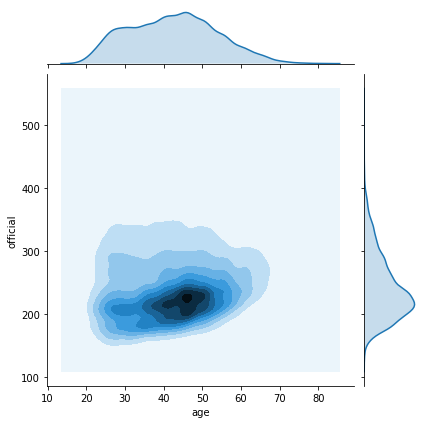

In [5]:
sns.jointplot(x=cdf['age'], y=cdf['official'], kind='kde',shade=True)

In [6]:
class KM_Clustering():
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
        # random sample indexes
        self.rsi = np.arange(df.shape[0]-df.shape[0]%4)
        np.random.shuffle(self.rsi) 
        self.rsi = np.split(self.rsi, n_samples)
        
        self.scaler = StandardScaler().fit(self.df)
        self.scaled = self.scaler.transform(self.df)
        
        self.pca = PCA().fit_transform(self.scaled)
        self.cl = {} # saved fitted clustering solutions
        
    
    def cluster_km(self, n_clusters, **kwargs):

        self.cl.setdefault(n_clusters, {})
        cll = [] # cluster label list
        for si in self.rsi: 

            km = KMeans(n_clusters=n_clusters, **kwargs)
            
            cll.append(km.fit(self.scaled[si,:]))
       
        self.cl[n_clusters] = cll
        
    def plot_clusters(self, n_clusters):
        rows = self.n_samples//2
        f, axarr = plt.subplots(rows, 2, figsize=(9,rows*3))

        for i, cluster in enumerate(self.cl[n_clusters]):
            labels = cluster.predict(self.scaled[self.rsi[i],:])
            row = i//2
            col = i%2
            si = self.rsi[i] # sample index
            axarr[row, col].scatter(x=self.pca[si,0], y=self.pca[si,1], c=labels)
            axarr[row, col].set_title('sample {}'.format(i))
        plt.suptitle('{} Clusters PCA'.format(n_clusters), fontsize=20)
        plt.show()
    
        
    def display_metrics(self, n_clusters):
        self.cl[n_clusters]
        print('{} Cluster Silhouette Scores:'.format(n_clusters))
        for i, cluster in enumerate(self.cl[n_clusters]):
            labels = cluster.predict(self.scaled[self.rsi[i],:])
            si = self.rsi[i]
            sample = self.scaled[si,:]
            sil_score = metrics.silhouette_score(sample, labels, sample_size=1000)
            print('sample {}: {}'.format(i, round(sil_score, 4)))
            
        print('\n{} Cluster Inertia Scores:'.format(n_clusters))
        for i, cluster in enumerate(self.cl[n_clusters]):
            inertia = cluster.inertia_
            print('sample {}: {}'.format(i, round(inertia, 4)))
        
        print('\n{} Cluster centers:'.format(n_clusters))
        for i, cluster in enumerate(self.cl[n_clusters]):
            center = cluster.cluster_centers_ * self.scaler.scale_ + self.scaler.mean_
            print('sample {}: \n{}'.format(i, center))
            
    def cluster_range(self, start=2, stop=6, step=1, plot=True, metrics=True):
        for i in range(start, stop, step):
            self.cluster_km(i)
            if metrics:
                self.display_metrics(i)
            if plot:
                self.plot_clusters(i)
                print('-'*120)

2 Cluster Silhouette Scores:
sample 0: 0.3731
sample 1: 0.3506
sample 2: 0.3509
sample 3: 0.3406

2 Cluster Inertia Scores:
sample 0: 9799.784
sample 1: 9931.3782
sample 2: 9751.0931
sample 3: 10081.2619

2 Cluster centers:
sample 0: 
[[ 49.81629585 279.96944378]
 [ 36.78302712 214.08125328]]
sample 1: 
[[ 36.2673918  213.75520508]
 [ 49.83271162 278.70612912]]
sample 2: 
[[ 35.78138425 213.81196181]
 [ 50.17745415 272.20516721]]
sample 3: 
[[ 36.47720504 214.54565178]
 [ 50.0031135  278.68801302]]


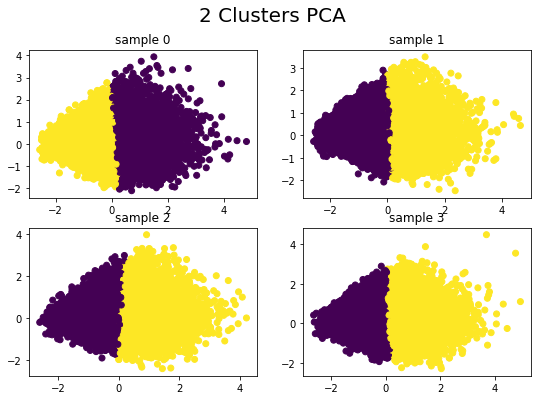

------------------------------------------------------------------------------------------------------------------------
3 Cluster Silhouette Scores:
sample 0: 0.382
sample 1: 0.3841
sample 2: 0.3805
sample 3: 0.3829

3 Cluster Inertia Scores:
sample 0: 6368.4007
sample 1: 6338.2978
sample 2: 6208.8511
sample 3: 6433.0782

3 Cluster centers:
sample 0: 
[[ 37.14691358 312.18285185]
 [ 53.24065821 244.51640384]
 [ 35.22166022 205.58384112]]
sample 1: 
[[ 33.84266409 206.29426641]
 [ 38.26194797 315.08901996]
 [ 52.68887472 239.90686962]]
sample 2: 
[[ 52.88914027 240.17037815]
 [ 38.5525974  316.72559091]
 [ 34.61151961 206.60671569]]
sample 3: 
[[ 53.02251958 240.69689948]
 [ 38.68209501 317.28777101]
 [ 34.43201754 207.5860589 ]]


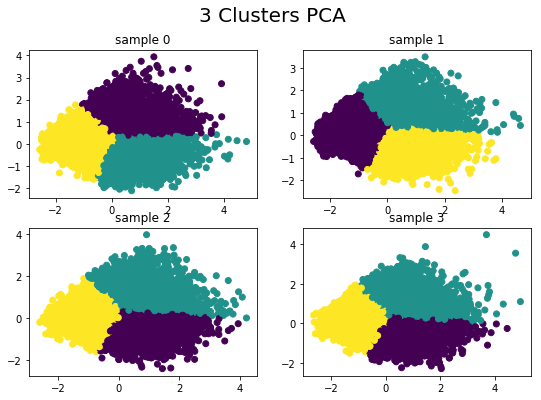

------------------------------------------------------------------------------------------------------------------------
4 Cluster Silhouette Scores:
sample 0: 0.3708
sample 1: 0.3923
sample 2: 0.3741
sample 3: 0.3727

4 Cluster Inertia Scores:
sample 0: 4730.3449
sample 1: 4582.5665
sample 2: 4632.6143
sample 3: 4781.5262

4 Cluster centers:
sample 0: 
[[ 31.82723667 202.69309828]
 [ 57.26236045 291.86674641]
 [ 34.2559775  304.87462729]
 [ 47.7907213  220.28940061]]
sample 1: 
[[ 31.39075447 203.43574357]
 [ 56.86174104 291.42801756]
 [ 47.97105445 220.15553756]
 [ 33.52844311 307.51568114]]
sample 2: 
[[ 31.51229325 204.05382655]
 [ 47.31465226 219.25070223]
 [ 35.11687363 310.05918188]
 [ 58.0962406  281.84125564]]
sample 3: 
[[ 32.24198988 204.19564503]
 [ 57.405515   294.62091646]
 [ 34.19641577 308.57282437]
 [ 48.62698413 221.88328847]]


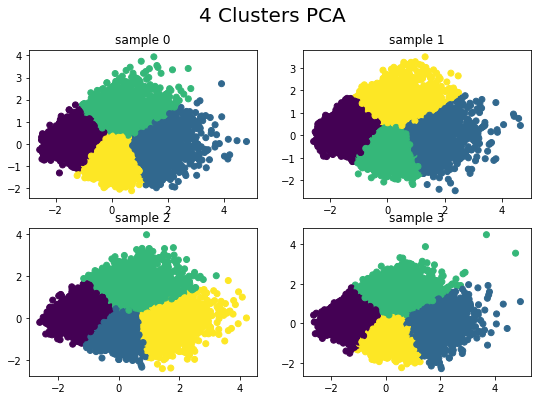

------------------------------------------------------------------------------------------------------------------------
5 Cluster Silhouette Scores:
sample 0: 0.3585
sample 1: 0.3519
sample 2: 0.3489
sample 3: 0.3527

5 Cluster Inertia Scores:
sample 0: 3934.721
sample 1: 3820.7825
sample 2: 3854.3102
sample 3: 3983.5986

5 Cluster centers:
sample 0: 
[[ 31.86886565 290.57830249]
 [ 56.89349931 257.01239972]
 [ 30.80777538 199.18651188]
 [ 45.36911488 215.1640339 ]
 [ 49.1011396  337.57146724]]
sample 1: 
[[ 44.58320064 215.22317277]
 [ 31.97548605 303.18141167]
 [ 56.67042254 245.59962676]
 [ 30.05293501 202.13171908]
 [ 52.66514286 320.99379429]]
sample 2: 
[[ 44.86322532 216.21062924]
 [ 52.39972715 327.06347885]
 [ 30.57875264 201.78987315]
 [ 32.44709898 301.34024744]
 [ 57.09951624 246.50389081]]
sample 3: 
[[ 44.93024162 215.1548597 ]
 [ 52.1125158  330.33537295]
 [ 32.2733119  299.6048955 ]
 [ 56.64304993 249.21363023]
 [ 30.45674931 201.47150413]]


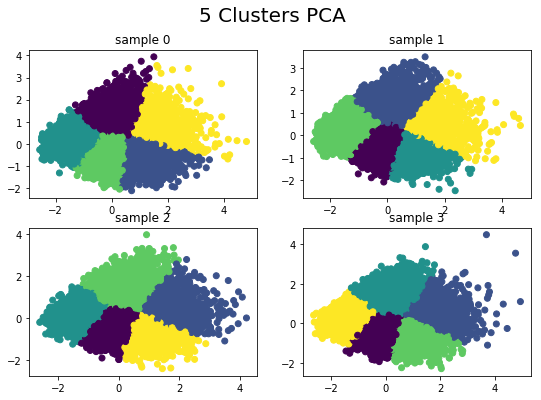

------------------------------------------------------------------------------------------------------------------------


In [7]:
c = KM_Clustering(cdf[['age','official']], 4)
c.cluster_range()

In [8]:
class SP_Clustering():
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
        # random sample indexes
        self.rsi = np.arange(df.shape[0]-df.shape[0]%4)
        np.random.shuffle(self.rsi) 
        self.rsi = np.split(self.rsi[:4000], n_samples)
        
        self.scaled = StandardScaler().fit_transform(self.df)
        self.pca = PCA().fit_transform(self.scaled)
        self.cl = {} # cluster labels
        
    
    def cluster_km(self, n_clusters, **kwargs):

        self.cl.setdefault(n_clusters, {})
        cll = [] # cluster label list
        for si in self.rsi: 

            sp = SpectralClustering(n_clusters=n_clusters, **kwargs)
            predict = sp.fit_predict(self.scaled[si,:])
            cll.append(predict)
       
        self.cl[n_clusters] = cll
        
    def plot_clusters(self, n_clusters):
        rows = self.n_samples//2
        f, axarr = plt.subplots(rows, 2, figsize=(9,rows*3))

        for i, labels in enumerate(self.cl[n_clusters]):
            row = i//2
            col = i%2
            si = self.rsi[i] # sample index
            axarr[row, col].scatter(x=self.pca[si,0], y=self.pca[si,1], c=labels)
            axarr[row, col].set_title('sample {}'.format(i))
        plt.suptitle('{} Clusters'.format(n_clusters), fontsize=20)
        plt.show()
        
    def display_metrics(self, n_clusters):
        self.cl[n_clusters]
        print('{} Cluster Silhouette Scores:'.format(n_clusters))
        for i, labels in enumerate(self.cl[n_clusters]):
            si = self.rsi[i]
            sample = self.scaled[si,:]
            sil_score = metrics.silhouette_score(sample, labels, sample_size=1000)
            print('sample {}: {}'.format(i, round(sil_score, 4)))
        
        
    def cluster_range(self, start=2, stop=6, step=1, plot=True, metrics=True):
        for i in range(start, stop, step):
            self.cluster_km(i)
            if metrics:
                self.display_metrics(i)
            if plot:
                self.plot_clusters(i)
                print('-'*120)

2 Cluster Silhouette Scores:
sample 0: 0.373
sample 1: 0.3365
sample 2: 0.3506
sample 3: 0.3458


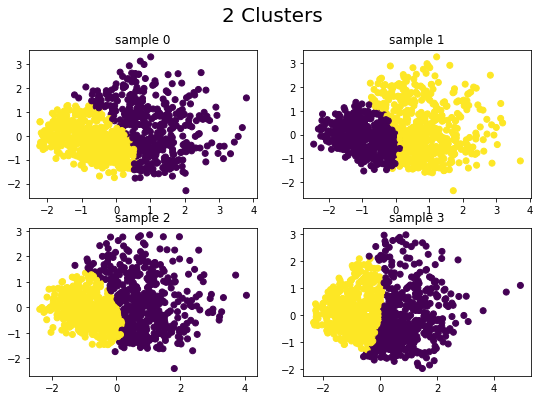

------------------------------------------------------------------------------------------------------------------------
3 Cluster Silhouette Scores:
sample 0: 0.3693
sample 1: 0.3912
sample 2: 0.3832
sample 3: 0.3664


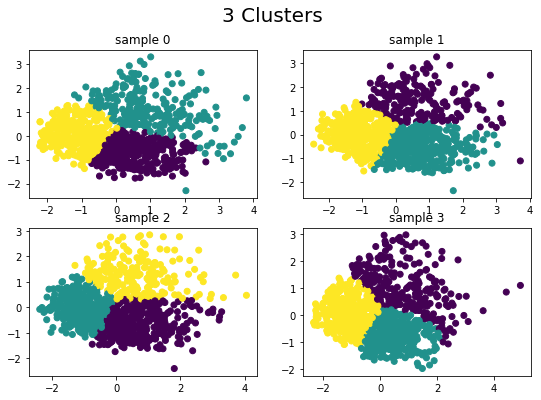

------------------------------------------------------------------------------------------------------------------------
4 Cluster Silhouette Scores:
sample 0: 0.3844
sample 1: 0.379
sample 2: 0.3822
sample 3: 0.3583


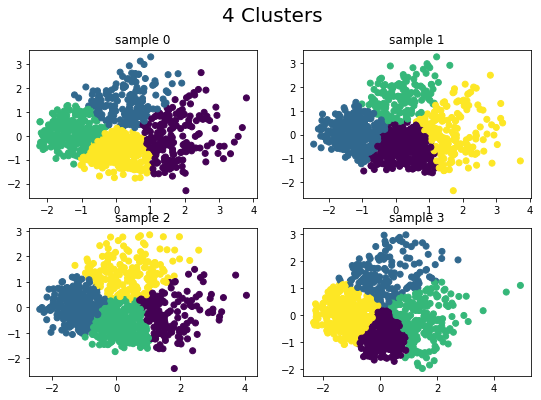

------------------------------------------------------------------------------------------------------------------------
5 Cluster Silhouette Scores:
sample 0: 0.3775
sample 1: 0.3592
sample 2: 0.3451
sample 3: 0.29


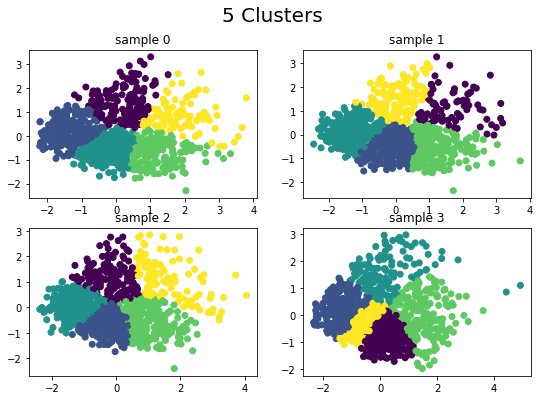

------------------------------------------------------------------------------------------------------------------------


In [9]:
sp = SP_Clustering(cdf[['age','official']], 4)
sp.cluster_range()

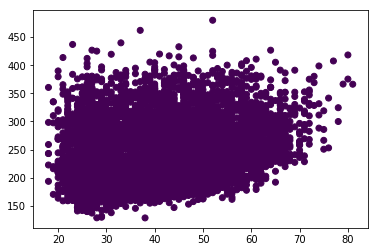

In [10]:
# mean shift
ms = MeanShift()
d = c.scaled[c.rsi[0],:]
predict=ms.fit_predict(d)

plt.scatter(cdf['age'].iloc[c.rsi[0]], cdf['official'].iloc[c.rsi[0]], c=predict)

KMeans 3 clusters seems to have stable by looking, and it had the best silhouette scores, so we'll use it to look at descriptive statistics of clusters.

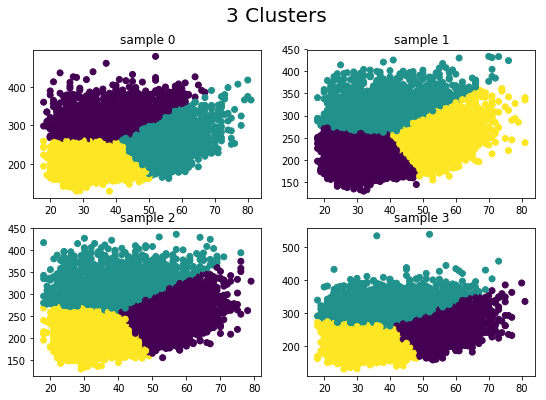

In [12]:
# 3 clusters across age (x axis) and running time (y axis) (not pca dimensions)

rows = c.n_samples//2
f, axarr = plt.subplots(rows, 2, figsize=(9,rows*3))

for i, cluster in enumerate(c.cl[3]):
        labels = cluster.predict(c.scaled[c.rsi[i],:])
        row = i//2
        col = i%2
        si = c.rsi[i] # sample index
        axarr[row, col].scatter(x=c.df.iloc[si,0], y=c.df.iloc[si,1], c=labels)
        axarr[row, col].set_title('sample {}'.format(i))
plt.suptitle('{} Clusters'.format(3), fontsize=20)
plt.show()
    

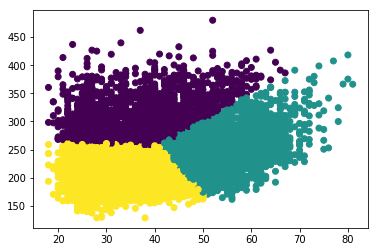

In [13]:
# Sample 0: top left from graph from previous cell
si = c.rsi[0] # sample index
labels = c.cl[3][0].predict(c.scaled[si,:])

plt.scatter(x=c.df.iloc[si,0], y=c.df.iloc[si,1], c=labels)
plt.show()

In [14]:
# descriptive stats of clusters (sample 0)
km = c.cl[3][0]
si = c.rsi[0]
df_sample0 = c.df.iloc[si].copy()
df_sample0['cluster'] = km.predict(c.scaled[si])

print('cluster membership size as % of all data')
print(df_sample0['cluster'].value_counts()/len(df_sample0)*100)

df_sample0.groupby('cluster').describe()

# print()

cluster membership size as % of all data
2    42.593062
1    36.870094
0    20.536845
Name: cluster, dtype: float64


age                                                    official  \
          count       mean       std   min   25%   50%   75%   max    count   
cluster                                                                       
0        1622.0  37.151048  9.216566  18.0  29.0  37.0  43.0  67.0   1622.0   
1        2912.0  53.256525  6.623075  41.0  48.0  52.0  57.0  81.0   2912.0   
2        3364.0  35.231570  6.943650  18.0  30.0  36.0  41.0  50.0   3364.0   

                                                                             
               mean        std     min       25%      50%       75%     max  
cluster                                                                      
0        312.122343  36.560295  258.18  281.8775  306.475  337.0075  479.80  
1        244.535649  34.326635  161.63  220.4450  239.460  264.8425  418.15  
2        205.590847  25.124536  128.62  186.9650  205.165  223.2000  263.58

in above stats:
cluster 0 (Slow Runners): 
    yellow, top most cluster 

cluster 1 (Old, Fast Runners): 
    teal, bottom right cluster
    
cluster 2 (Young, Fast Runners):
    purple, bottom left cluster

# Questions:
- How is clustering useful on this data? 
    - age and running time are slightly correlated but they don't interact with each other in any interesting or unexpected way. If they are mapped on a 2d kde plot, it really just looks like a single cluster.
    - the other possible variables in this dataset fall into one of the following categories:
        - directly derived from running time (pace, overall placing)
        - extremely linearly correlated with running time (10k, 5k, half...)
        - categorical data (gender, country...) which I'm not sure can be meaningfully implemented in algorithms that use euclidean distance
    - I'm either not understanding something important about this clustering or this data (which is definitely possible), or this just isn't data where clustering proves very useful